In [ ]:
# !conda install -c conda-forge xarray dask netCDF4 bottleneck -y

In [3]:
import h5py

import numpy as np

import operator
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# from metpy.calc.kinematics import vector_derivative, first_derivative
from metpy.calc.tools import vector_derivative, first_derivative

import metpy

import torch
from torch.nn.functional import conv2d, conv1d
from metpy.units import units
import functools
from metpy.package_tools import Exporter
from inspect import Parameter, signature

from pyproj import CRS, Geod, Proj
import contextlib

from metpy import _warnings

In [4]:
import copy

In [5]:
import netCDF4

In [6]:
def _add_grid_params_to_docstring(docstring: str, orig_includes: dict) -> str:
    """Add documentation for some dynamically added grid parameters to the docstring."""
    other_params = docstring.find('Other Parameters')
    blank = docstring.find('\n\n', other_params)

    entries = {
        'longitude': """
    longitude : `pint.Quantity`, optional
        Longitude of data. Optional if `xarray.DataArray` with latitude/longitude coordinates
        used as input. Also optional if parallel_scale and meridional_scale are given. If
        otherwise omitted, calculation will be carried out on a Cartesian, rather than
        geospatial, grid. Keyword-only argument.""",
        'latitude': """
    latitude : `pint.Quantity`, optional
        Latitude of data. Optional if `xarray.DataArray` with latitude/longitude coordinates
        used as input. Also optional if parallel_scale and meridional_scale are given. If
        otherwise omitted, calculation will be carried out on a Cartesian, rather than
        geospatial, grid. Keyword-only argument.""",
        'crs': """
    crs : `pyproj.crs.CRS`, optional
        Coordinate Reference System of data. Optional if `xarray.DataArray` with MetPy CRS
        used as input. Also optional if parallel_scale and meridional_scale are given. If
        otherwise omitted, calculation will be carried out on a Cartesian, rather than
        geospatial, grid. Keyword-only argument."""
    }

    return ''.join([docstring[:blank],
                    *(entries[p] for p, included in orig_includes.items() if not included),
                    docstring[blank:]])

In [7]:
def parse_grid_arguments(func):
    """Parse arguments to functions involving derivatives on a grid."""
    from metpy.xarray import dataarray_arguments

    # Dynamically add new parameters for lat, lon, and crs to the function signature
    # which is used to handle arguments inside the wrapper--but only if they're not in the
    # original signature
    sig = signature(func)
    orig_func_uses = {param: param in sig.parameters
                      for param in ('latitude', 'longitude', 'crs')}
    newsig = sig.replace(parameters=[*sig.parameters.values(),
                                     *(Parameter(name, Parameter.KEYWORD_ONLY, default=None)
                                       for name, needed in orig_func_uses.items()
                                       if not needed)])

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        bound_args = newsig.bind(*args, **kwargs)
        bound_args.apply_defaults()
        scale_lat = latitude = bound_args.arguments.pop('latitude')
        scale_lon = longitude = bound_args.arguments.pop('longitude')
        crs = bound_args.arguments.pop('crs')

        print("scale_lat",scale_lat)

        # Choose the first DataArray argument to act as grid prototype
        grid_prototype = next(dataarray_arguments(bound_args), None)

        # Fill in x_dim/y_dim
        if (
            grid_prototype is not None
            and 'x_dim' in bound_args.arguments
            and 'y_dim' in bound_args.arguments
        ):
            try:
                bound_args.arguments['x_dim'] = grid_prototype.metpy.find_axis_number('x')
                bound_args.arguments['y_dim'] = grid_prototype.metpy.find_axis_number('y')
            except AttributeError:
                # If axis number not found, fall back to default but warn.
                _warnings.warn('Horizontal dimension numbers not found. Defaulting to '
                               '(..., Y, X) order.')

        # Fill in vertical_dim
        if (
            grid_prototype is not None
            and 'vertical_dim' in bound_args.arguments
        ):
            try:
                bound_args.arguments['vertical_dim'] = (
                    grid_prototype.metpy.find_axis_number('vertical')
                )
            except AttributeError:
                # If axis number not found, fall back to default but warn.
                _warnings.warn(
                    'Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.'
                )

        # Fill in dz
        if (
            grid_prototype is not None
            and 'dz' in bound_args.arguments
        ):
            if bound_args.arguments['dz'] is None:
                try:
                    vertical_coord = grid_prototype.metpy.vertical
                    bound_args.arguments['dz'] = np.diff(vertical_coord.metpy.unit_array)
                except (AttributeError, ValueError):
                    # Skip, since this only comes up in advection, where dz is optional
                    # (may not need vertical at all)
                    pass
            if (
                func.__name__.endswith('advection')
                and bound_args.arguments['u'] is None
                and bound_args.arguments['v'] is None
            ):
                return func(*bound_args.args, **bound_args.kwargs)

        # Fill in dx and dy
        if (
            'dx' in bound_args.arguments and bound_args.arguments['dx'] is None
            and 'dy' in bound_args.arguments and bound_args.arguments['dy'] is None
        ):
            if grid_prototype is not None:
                grid_deltas = grid_prototype.metpy.grid_deltas
                bound_args.arguments['dx'] = grid_deltas['dx']
                bound_args.arguments['dy'] = grid_deltas['dy']
            elif longitude is not None and latitude is not None and crs is not None:
                # TODO: de-duplicate .metpy.grid_deltas code
                geod = None if crs is None else crs.get_geod()
                bound_args.arguments['dx'], bound_args.arguments['dy'] = (
                    nominal_lat_lon_grid_deltas(longitude, latitude, geod)
                )
            elif 'dz' in bound_args.arguments:
                # Handle advection case, allowing dx/dy to be None but dz to not be None
                if bound_args.arguments['dz'] is None:
                    raise ValueError(
                        'Must provide dx, dy, and/or dz arguments or input DataArray with '
                        'interpretable dimension coordinates.'
                    )
            else:
                raise ValueError(
                    'Must provide dx/dy arguments, input DataArray with interpretable '
                    'dimension coordinates, or 1D longitude/latitude arguments with an '
                    'optional PyProj CRS.'
                )

        # Fill in parallel_scale and meridional_scale
        if (
            'parallel_scale' in bound_args.arguments
            and bound_args.arguments['parallel_scale'] is None
            and 'meridional_scale' in bound_args.arguments
            and bound_args.arguments['meridional_scale'] is None
        ):
            proj = None
            if grid_prototype is not None:
                # Fall back to basic cartesian calculation if we don't have a CRS or we
                # are unable to get the coordinates needed for map factor calculation
                # (either existing lat/lon or lat/lon computed from y/x)
                with contextlib.suppress(AttributeError):
                    latitude, longitude = grid_prototype.metpy.coordinates('latitude',
                                                                           'longitude')
                    scale_lat = latitude.metpy.unit_array
                    scale_lon = longitude.metpy.unit_array
                    if hasattr(grid_prototype.metpy, 'pyproj_proj'):
                        proj = grid_prototype.metpy.pyproj_proj
                    elif latitude.squeeze().ndim == 1 and longitude.squeeze().ndim == 1:
                        proj = Proj(CRS('+proj=latlon'))
            elif latitude is not None and longitude is not None:
                try:
                    proj = Proj(crs)
                except Exception as e:
                    # Whoops, intended to use
                    raise ValueError(
                        'Latitude and longitude arguments provided so as to make '
                        'calculation projection-correct, however, projection CRS is '
                        'missing or invalid.'
                    ) from e

            # Do we have everything we need to sensibly calculate the scale arrays?
            if proj is not None:
                scale_lat = scale_lat.squeeze().m_as('degrees')
                scale_lon = scale_lon.squeeze().m_as('degrees')
                if scale_lat.ndim == 1 and scale_lon.ndim == 1:
                    scale_lon, scale_lat = np.meshgrid(scale_lon, scale_lat)
                elif scale_lat.ndim != 2 or scale_lon.ndim != 2:
                    raise ValueError('Latitude and longitude must be either 1D or 2D.')
                factors = proj.get_factors(scale_lon, scale_lat)
                p_scale = factors.parallel_scale
                m_scale = factors.meridional_scale

                if grid_prototype is not None:
                    # Set the dims and coords using the original from the input lat/lon.
                    # This particular implementation relies on them being 1D/2D for the dims.
                    xr_kwargs = {'coords': {**latitude.coords, **longitude.coords},
                                 'dims': (latitude.dims[0], longitude.dims[-1])}
                    p_scale = xr.DataArray(p_scale, **xr_kwargs)
                    m_scale = xr.DataArray(m_scale, **xr_kwargs)

                bound_args.arguments['parallel_scale'] = p_scale
                bound_args.arguments['meridional_scale'] = m_scale

        # If the original function uses any of the arguments that are otherwise dynamically
        # added, be sure to pass them to the original function.
        local_namespace = vars()
        bound_args.arguments.update({param: local_namespace[param]
                                     for param, uses in orig_func_uses.items() if uses})

        return func(*bound_args.args, **bound_args.kwargs)

    # Override the wrapper function's signature with a better signature. Also add docstrings
    # for our added parameters.
    wrapper.__signature__ = newsig
    if getattr(wrapper, '__doc__', None) is not None:
        wrapper.__doc__ = _add_grid_params_to_docstring(wrapper.__doc__, orig_func_uses)

    return wrapper

# Import data

In [8]:
# !wget https://gist.githubusercontent.com/Yegorov/dc61c42aa4e89e139cd8248f59af6b3e/raw/20ac954e202fe6a038c2b4bb476703c02fe0df87/ya.py
# !chmod +x ya.py
# !./ya.py https://disk.yandex.ru/d/9htuAC5BtSb9FA
# !unzip data.zip

In [12]:
vorticity = xr.open_mfdataset('/home/fa.buzaev/data_5/vorticity/vorticity_2013_5.625deg.nc', combine='by_coords')
u_component_of_wind = xr.open_mfdataset('/home/fa.buzaev/data_5/u_component_of_wind/u_component_of_wind_2013_5.625deg.nc', combine='by_coords')
v_component_of_wind = xr.open_mfdataset('/home/fa.buzaev/data_5/v_component_of_wind/v_component_of_wind_2013_5.625deg.nc', combine='by_coords')

In [13]:
u_component_of_wind

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, level: 13, time: 8760)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    u        (time, level, lat, lon) float32 dask.array<chunksize=(8760, 13, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-02 03:29:48 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [14]:
vorticity

<xarray.Dataset>
Dimensions:  (lon: 64, level: 13, lat: 32, time: 8760)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    vo       (time, level, lat, lon) float32 dask.array<chunksize=(8760, 13, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-21 09:31:55 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

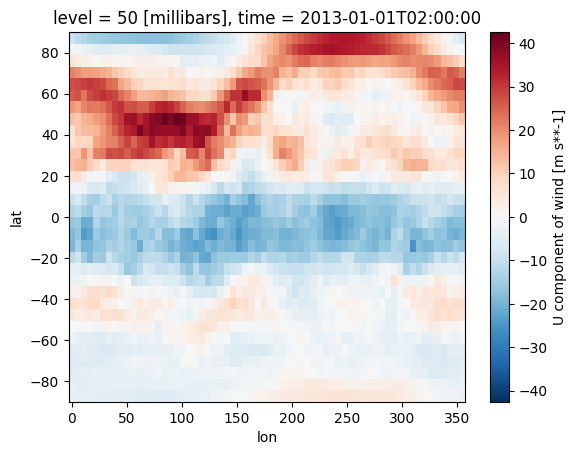

In [15]:
u_component_of_wind.u.isel(time=2, level=0).plot()

In [16]:
v_component_of_wind

<xarray.Dataset>
Dimensions:  (lat: 32, level: 13, lon: 64, time: 8760)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    v        (time, level, lat, lon) float32 dask.array<chunksize=(8760, 13, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-02-29 15:23:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

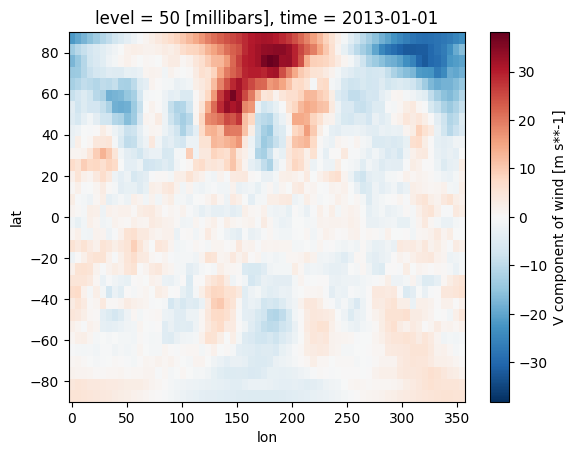

In [17]:
v_component_of_wind.v.isel(time=0, level=0).plot()

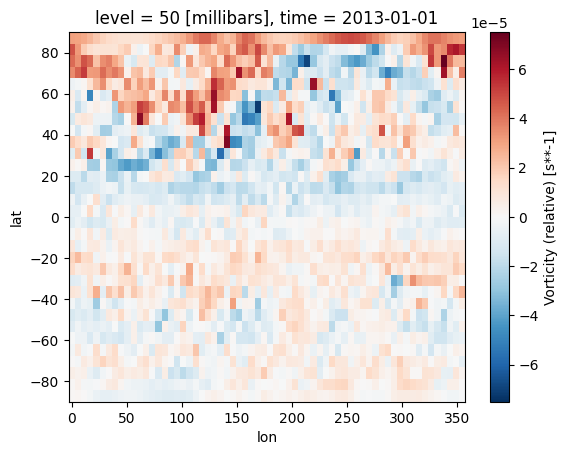

In [18]:
vorticity.vo.isel(time=0, level=0).plot()

# Functions

In [19]:
u_wind = u_component_of_wind.u.isel(time=0, level=0)
v_wind = v_component_of_wind.v.isel(time=0, level=0)
vor = vorticity.vo.isel(time=0, level=0)

In [20]:
u_wind_changed = copy.deepcopy(u_wind)

v_wind_changed = copy.deepcopy(v_wind)

# u_wind_changed = rescaleDDX(u_wind_changed)

## Teст со сверткой

In [21]:
u_wind_np = u_wind_changed.to_numpy()
weights_y = torch.tensor([[-1], [0], [1]], dtype=torch.float32)
weights_y = weights_y.unsqueeze(0).unsqueeze(0)
u_wind_torch = torch.Tensor(u_wind_np).unsqueeze(0).unsqueeze(0)

# conv_diff_du_dy = conv2d(input=u_wind_torch, weight=weights_y, padding=1)
conv_diff_du_dy = conv2d(input=u_wind_torch, weight=weights_y)
# Временно паддим и обрезаем
conv_diff_du_dy = conv_diff_du_dy[:, :, :, :128]

In [22]:
v_wind_np = v_wind_changed.to_numpy()
weights_x = torch.tensor([[-1, 0, 1]], dtype=torch.float32)
weights_x = weights_x.unsqueeze(0).unsqueeze(0) # Для батчинга
v_wind_torch = torch.Tensor(v_wind_np).unsqueeze(0).unsqueeze(0) # Для батчинга

conv_diff_dv_dx = conv2d(input=v_wind_torch, weight=weights_x, padding=1)
# Временно паддим и обрезаем
conv_diff_dv_dx = conv_diff_dv_dx[:, :, 2:, :128]

In [23]:
du_dy, dv_dx = vector_derivative(u_wind, v_wind, x_dim=1, y_dim=0, return_only=('du/dy', 'dv/dx'))

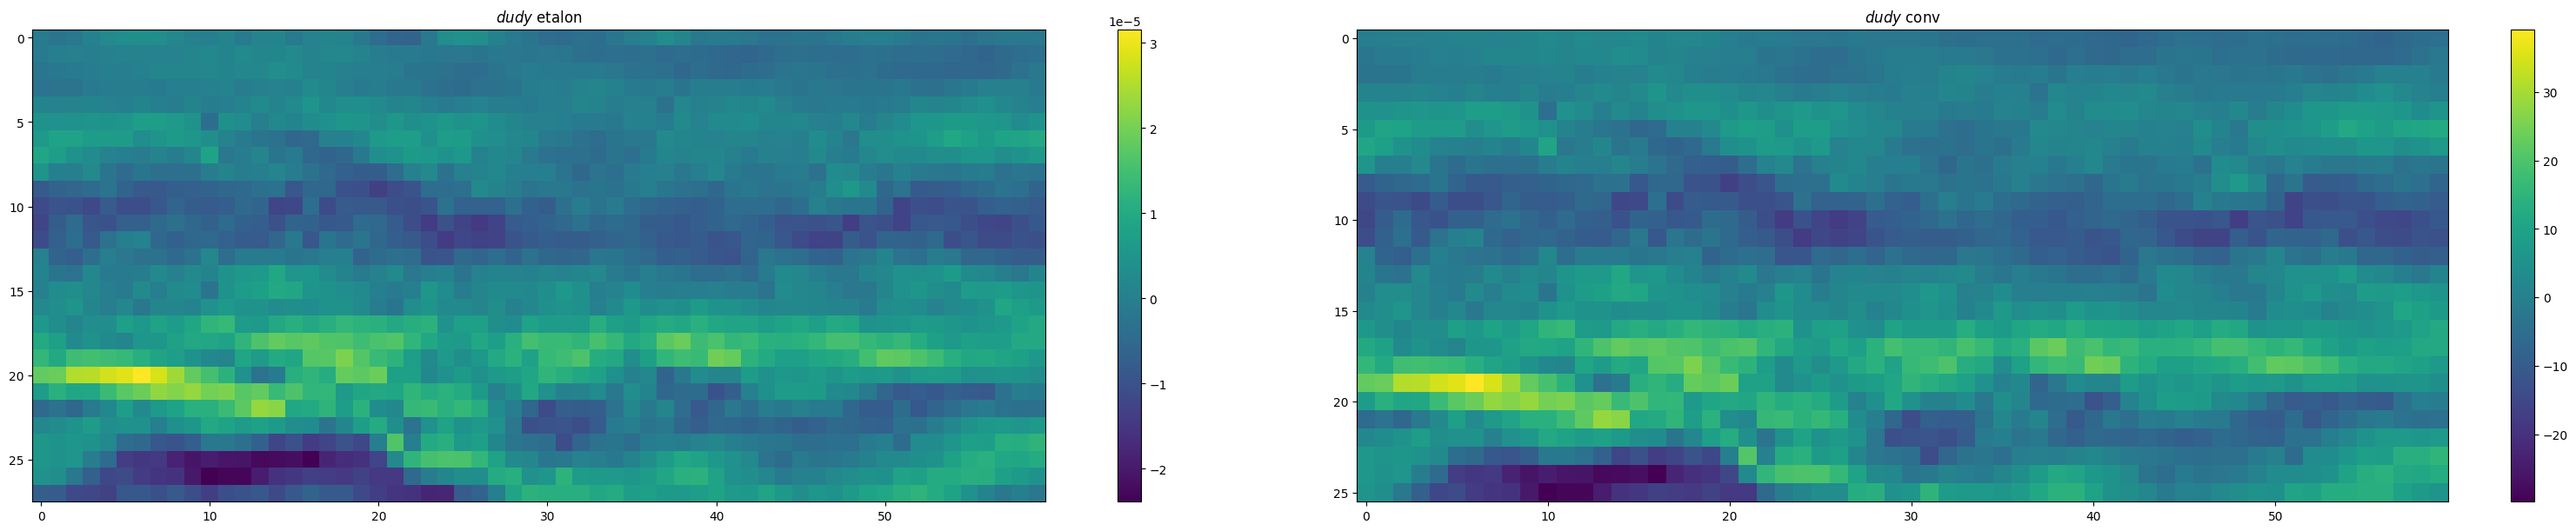

In [24]:
plt.figure(constrained_layout=True, figsize=(32, 6))
plt.subplot(121)
plt.imshow(du_dy[:-4, 4:])
plt.title("$du dy$ etalon")
plt.colorbar()

plt.subplot(122)
plt.imshow(conv_diff_du_dy.squeeze().numpy()[:-4, 4:])
plt.title("$du dy$ conv")
plt.colorbar()
plt.savefig("du_dy_conv.png")

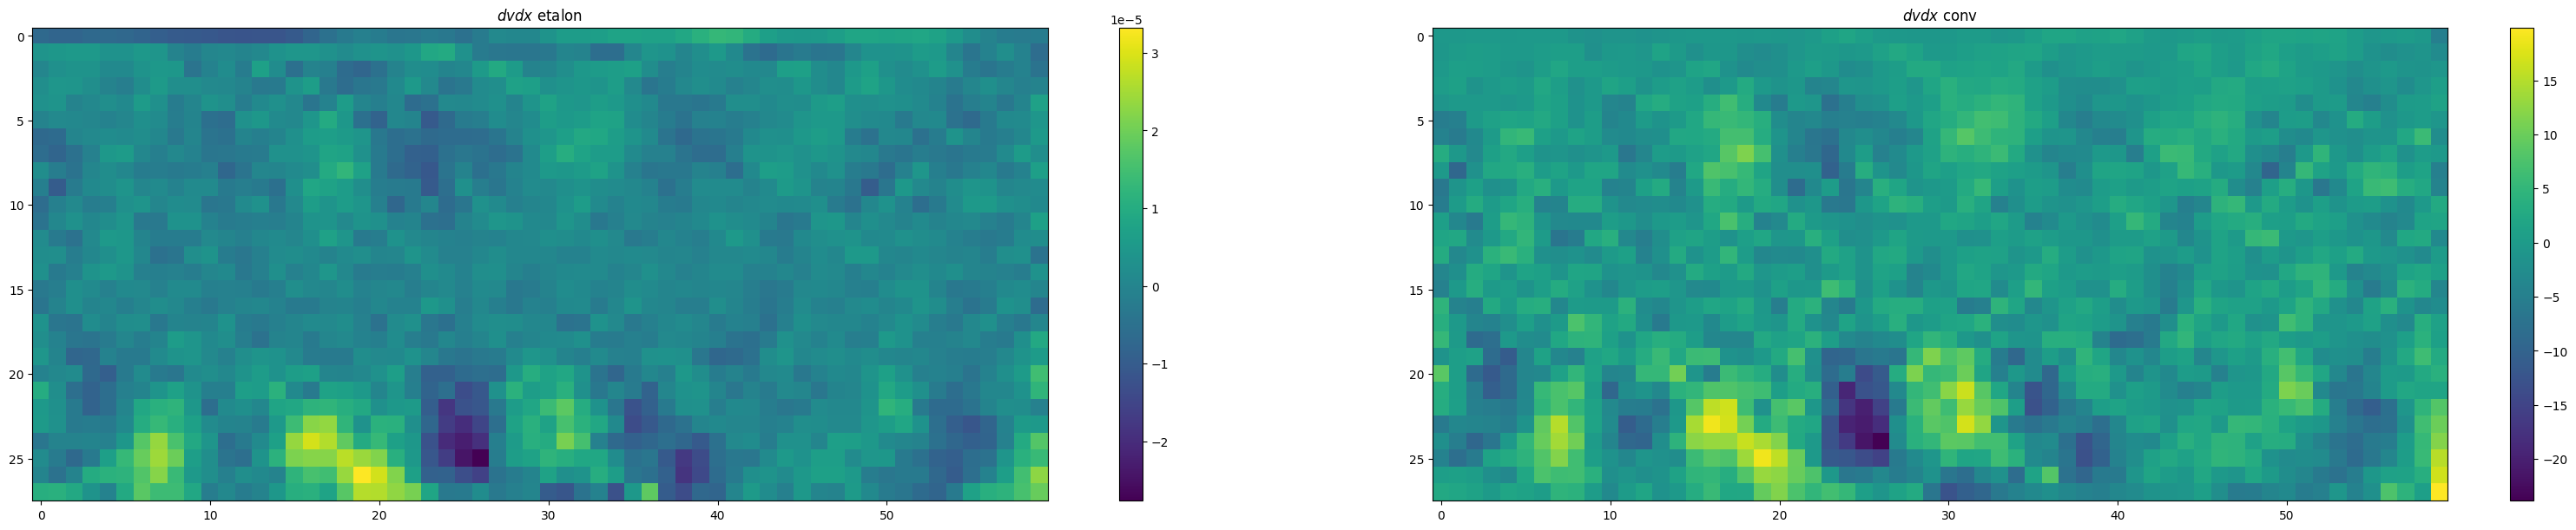

In [25]:
plt.figure(constrained_layout=True, figsize=(32, 6))
plt.subplot(121)
plt.imshow(dv_dx[:-4, 4:])
plt.title("$dv dx$ etalon")
plt.colorbar()

plt.subplot(122)
plt.imshow(conv_diff_dv_dx.squeeze().numpy()[:-4, 4:])
plt.title("$dv dx$ conv")
plt.colorbar()
plt.savefig("dv_dx_conv.png")

In [ ]:
diff_etalon = du_dy[:-4, 4:] - dv_dx[:-4, 4:]
diff_conv = conv_diff_du_dy.squeeze().numpy()[:-4, 4:] - conv_diff_dv_dx.squeeze().numpy()[:-4, 4:]

plt.figure(constrained_layout=True, figsize=(32, 6))
plt.subplot(121)
plt.imshow(diff_etalon[:, :-2])
plt.title("diff etalon")
plt.colorbar()

plt.subplot(122)
plt.imshow(diff_conv[:, :-2])
plt.title("diff conv")
plt.colorbar()

ValueError: operands could not be broadcast together with shapes (58,124) (60,124) 

## Разбор функций

In [26]:
from metpy.units import check_units, concatenate, units
from metpy.xarray import check_axis, grid_deltas_from_dataarray, preprocess_and_wrap
from metpy.package_tools import Exporter


exporter = Exporter(globals())

У нас сетка в $\theta$ и $\phi$. Она сонаправлена XY (условно, ось У смотрит на север, ось Х - на восток).

Каждая ячейка - прямоугольная в ХУ и в $\theta$ $\phi$.

Производная по Х - разница значения справа и значения слева, поделенная на 2*ширина ячейки.

Производная по У - разница значения сверху и значения снизу, поделенная на 2*высоту ячейки.

высота ячейки одинакова и задается гранулярностью $\theta$

ширина - уменьшается к полюсам как $cos(\theta)$, но одинакова для всех матриц

Как происходит рассчет производных:

1. @parse_grid_arguments - Динамически добавлять новые параметры для lat, lon и crs в сигнатуру функции, которая используется для обработки аргументов внутри оболочки, но только если их нет в исходной сигнатуре.
То есть данный декоратор расширяет функцию vector_derivative, инициилизируя dx, dy, meridional_scale, parallel_scale.
1.1. dx и dy находятся с помощью функции nominal_lat_lon_grid_deltas

dx считается по формуле: a * deg2rad(diff(longtitude)), где а - большая полуось эллипса https://en.wikipedia.org/wiki/Earth_ellipsoid , a = 6378136

dy считается, как определние прямого и обратного азимутов, а также расстояния между начальными и конечными точками.
То есть используют вот это: https://pyproj4.github.io/pyproj/stable/api/geod.html#pyproj.Geod.inv

1.2. meridional_scale, parallel_scale - это константы для нашей размерной сетки. Берутся они из https://ru.wikipedia.org/wiki/WGS_84

2. Берется производная с помощью функции first_derivative(scalar, delta, dim), где скаляр - это данные, дельта - dx или dy в зависимости от производной, dim - направление производной.
delta это - расстояние между точками сетки в скаляре.

3. map correction - посчитанная производная корректируется под реалии Земли.

Сначала дополнительно вычисляется коэффициенты dy и dx коррекций.

dx_correction = meridional_scale / parallel_scale * derivatives['d_parallel_scale/dy']
dy_correction = parallel_scale / meridional_scale * derivatives['d_meridional_scale/dx']

А после нормируются итоговые производные.

derivatives['du/dy'] = meridional_scale * derivatives['du/dy'] + v * dy_correction
derivatives['dv/dx'] = parallel_scale * derivatives['dv/dx'] + u * dx_correction




In [27]:
@preprocess_and_wrap()
def nominal_lat_lon_grid_deltas(longitude, latitude, geod=None):
    """Calculate the nominal deltas along axes of a latitude/longitude grid."""
    if geod is None:
        geod = CRS('+proj=latlon').get_geod()

    # This allows working with coordinates that have been manually broadcast
    longitude = longitude.squeeze()
    latitude = latitude.squeeze()

    if longitude.ndim != 1 or latitude.ndim != 1:
        raise ValueError(
            'Cannot calculate nominal grid spacing from longitude and latitude arguments '
            'that are not one dimensional.'
        )

    dx = units.Quantity(geod.a * np.diff(longitude).m_as('radian'), 'meter')
    lat = latitude.m_as('degree')
    lon_meridian_diff = np.zeros(len(lat) - 1, dtype=lat.dtype)
    forward_az, _, dy = geod.inv(lon_meridian_diff, lat[:-1], lon_meridian_diff, lat[1:],
                                 radians=False)
    dy[(forward_az < -90.) | (forward_az > 90.)] *= -1
    dy = units.Quantity(dy, 'meter')

    return dx, dy

In [28]:
def parse_grid_arguments(func):
    """Parse arguments to functions involving derivatives on a grid."""
    from metpy.xarray import dataarray_arguments

    # Dynamically add new parameters for lat, lon, and crs to the function signature
    # which is used to handle arguments inside the wrapper--but only if they're not in the
    # original signature
    sig = signature(func)
    orig_func_uses = {param: param in sig.parameters
                      for param in ('latitude', 'longitude', 'crs')}
    newsig = sig.replace(parameters=[*sig.parameters.values(),
                                     *(Parameter(name, Parameter.KEYWORD_ONLY, default=None)
                                       for name, needed in orig_func_uses.items()
                                       if not needed)])

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        bound_args = newsig.bind(*args, **kwargs)
        bound_args.apply_defaults()
        scale_lat = latitude = bound_args.arguments.pop('latitude')
        scale_lon = longitude = bound_args.arguments.pop('longitude')
        crs = bound_args.arguments.pop('crs')

        # Choose the first DataArray argument to act as grid prototype
        grid_prototype = next(dataarray_arguments(bound_args), None)

        # print("grid_prototype", grid_prototype)

        # Fill in x_dim/y_dim
        if (
            grid_prototype is not None
            and 'x_dim' in bound_args.arguments
            and 'y_dim' in bound_args.arguments
        ):
            try:
                bound_args.arguments['x_dim'] = grid_prototype.metpy.find_axis_number('x')
                bound_args.arguments['y_dim'] = grid_prototype.metpy.find_axis_number('y')
            except AttributeError:
                # If axis number not found, fall back to default but warn.
                _warnings.warn('Horizontal dimension numbers not found. Defaulting to '
                               '(..., Y, X) order.')

        # Fill in vertical_dim
        if (
            grid_prototype is not None
            and 'vertical_dim' in bound_args.arguments
        ):
            try:
                bound_args.arguments['vertical_dim'] = (
                    grid_prototype.metpy.find_axis_number('vertical')
                )
            except AttributeError:
                # If axis number not found, fall back to default but warn.
                _warnings.warn(
                    'Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.'
                )

        # Fill in dz
        if (
            grid_prototype is not None
            and 'dz' in bound_args.arguments
        ):
            if bound_args.arguments['dz'] is None:
                try:
                    vertical_coord = grid_prototype.metpy.vertical
                    bound_args.arguments['dz'] = np.diff(vertical_coord.metpy.unit_array)
                except (AttributeError, ValueError):
                    # Skip, since this only comes up in advection, where dz is optional
                    # (may not need vertical at all)
                    pass
            if (
                func.__name__.endswith('advection')
                and bound_args.arguments['u'] is None
                and bound_args.arguments['v'] is None
            ):
                return func(*bound_args.args, **bound_args.kwargs)

        # Fill in dx and dy
        if (
            'dx' in bound_args.arguments and bound_args.arguments['dx'] is None
            and 'dy' in bound_args.arguments and bound_args.arguments['dy'] is None
        ):
            if grid_prototype is not None:
                grid_deltas = grid_prototype.metpy.grid_deltas
                # print("grid_deltas", grid_deltas)
                bound_args.arguments['dx'] = grid_deltas['dx']
                bound_args.arguments['dy'] = grid_deltas['dy']
            elif longitude is not None and latitude is not None and crs is not None:
                # TODO: de-duplicate .metpy.grid_deltas code
                geod = None if crs is None else crs.get_geod()
                bound_args.arguments['dx'], bound_args.arguments['dy'] = (
                    nominal_lat_lon_grid_deltas(longitude, latitude, geod)
                )
            elif 'dz' in bound_args.arguments:
                # Handle advection case, allowing dx/dy to be None but dz to not be None
                if bound_args.arguments['dz'] is None:
                    raise ValueError(
                        'Must provide dx, dy, and/or dz arguments or input DataArray with '
                        'interpretable dimension coordinates.'
                    )
            else:
                raise ValueError(
                    'Must provide dx/dy arguments, input DataArray with interpretable '
                    'dimension coordinates, or 1D longitude/latitude arguments with an '
                    'optional PyProj CRS.'
                )

        # Fill in parallel_scale and meridional_scale
        if (
            'parallel_scale' in bound_args.arguments
            and bound_args.arguments['parallel_scale'] is None
            and 'meridional_scale' in bound_args.arguments
            and bound_args.arguments['meridional_scale'] is None
        ):
            proj = None
            if grid_prototype is not None:
                # Fall back to basic cartesian calculation if we don't have a CRS or we
                # are unable to get the coordinates needed for map factor calculation
                # (either existing lat/lon or lat/lon computed from y/x)
                with contextlib.suppress(AttributeError):
                    latitude, longitude = grid_prototype.metpy.coordinates('latitude',
                                                                           'longitude')
                    scale_lat = latitude.metpy.unit_array
                    scale_lon = longitude.metpy.unit_array
                    if hasattr(grid_prototype.metpy, 'pyproj_proj'):
                        proj = grid_prototype.metpy.pyproj_proj
                    elif latitude.squeeze().ndim == 1 and longitude.squeeze().ndim == 1:
                        proj = Proj(CRS('+proj=latlon'))
            elif latitude is not None and longitude is not None:
                try:
                    proj = Proj(crs)
                except Exception as e:
                    # Whoops, intended to use
                    raise ValueError(
                        'Latitude and longitude arguments provided so as to make '
                        'calculation projection-correct, however, projection CRS is '
                        'missing or invalid.'
                    ) from e

            # Do we have everything we need to sensibly calculate the scale arrays?
            if proj is not None:
                scale_lat = scale_lat.squeeze().m_as('degrees')
                # print("scale_lat", scale_lat)
                scale_lon = scale_lon.squeeze().m_as('degrees')
                if scale_lat.ndim == 1 and scale_lon.ndim == 1:
                    scale_lon, scale_lat = np.meshgrid(scale_lon, scale_lat)
                elif scale_lat.ndim != 2 or scale_lon.ndim != 2:
                    raise ValueError('Latitude and longitude must be either 1D or 2D.')
                factors = proj.get_factors(scale_lon, scale_lat)
                p_scale = factors.parallel_scale
                m_scale = factors.meridional_scale

                if grid_prototype is not None:
                    # Set the dims and coords using the original from the input lat/lon.
                    # This particular implementation relies on them being 1D/2D for the dims.
                    xr_kwargs = {'coords': {**latitude.coords, **longitude.coords},
                                 'dims': (latitude.dims[0], longitude.dims[-1])}
                    p_scale = xr.DataArray(p_scale, **xr_kwargs)
                    m_scale = xr.DataArray(m_scale, **xr_kwargs)

                bound_args.arguments['parallel_scale'] = p_scale
                bound_args.arguments['meridional_scale'] = m_scale

        # If the original function uses any of the arguments that are otherwise dynamically
        # added, be sure to pass them to the original function.
        local_namespace = vars()
        bound_args.arguments.update({param: local_namespace[param]
                                     for param, uses in orig_func_uses.items() if uses})

        return func(*bound_args.args, **bound_args.kwargs)

    # Override the wrapper function's signature with a better signature. Also add docstrings
    # for our added parameters.
    wrapper.__signature__ = newsig
    if getattr(wrapper, '__doc__', None) is not None:
        wrapper.__doc__ = _add_grid_params_to_docstring(wrapper.__doc__, orig_func_uses)

    return wrapper

In [29]:
@exporter.export
@parse_grid_arguments
@preprocess_and_wrap(wrap_like=None,
                     broadcast=('u', 'v', 'parallel_scale', 'meridional_scale'))
@check_units(dx='[length]', dy='[length]')
def vector_derivative_1(u, v, *, dx=None, dy=None, x_dim=-1, y_dim=-2,
                      parallel_scale=None, meridional_scale=None, return_only=None):
    # print("meridional_scale", meridional_scale)
    # print("parallel_scale", parallel_scale)
    # Determine which derivatives to calculate
    derivatives = {
        component: None
        for component in ('du/dx', 'du/dy', 'dv/dx', 'dv/dy')
        if (return_only is None or component in return_only)
    }
    map_factor_correction = parallel_scale is not None and meridional_scale is not None
    # Add in the map factor derivatives if needed
    if map_factor_correction and ('du/dx' in derivatives or 'dv/dx' in derivatives):
        derivatives['dp/dy'] = None
    if map_factor_correction and ('du/dy' in derivatives or 'dv/dy' in derivatives):
        derivatives['dm/dx'] = None

    # print("dx", dx)

    # Compute the Cartesian derivatives
    for component in derivatives:
        scalar = {
            'du': u, 'dv': v, 'dp': parallel_scale, 'dm': meridional_scale
        }[component[:2]]
        delta, dim = (dx, x_dim) if component[-2:] == 'dx' else (dy, y_dim)
        if component[-2:] == 'dx':
            delta_dx = delta
        if component[-2:] == 'dy':
            delta_dy = delta
        # print("dim", dim)
        # print("dx", dx)
        # print("dy", dy)
        print("component", component)
        print("scalar", scalar)
        print("delta", delta)
        print("dim", dim)
        derivatives[component] = first_derivative(scalar, delta=delta, axis=dim)



    # Apply map factor corrections
    if map_factor_correction:
        # Factor against opposite component
        if 'dp/dy' in derivatives:
            print("derivatives['dp/dy'].shape", derivatives['dp/dy'].shape)
            dx_correction = meridional_scale / parallel_scale * derivatives['dp/dy']
        if 'dm/dx' in derivatives:
            dy_correction = parallel_scale / meridional_scale * derivatives['dm/dx']
        # Corrected terms
        if 'du/dx' in derivatives:
            derivatives['du/dx'] = parallel_scale * derivatives['du/dx'] - v * dx_correction
        if 'du/dy' in derivatives:
            derivatives['du/dy'] = meridional_scale * derivatives['du/dy'] + v * dy_correction
        if 'dv/dx' in derivatives:
            derivatives['dv/dx'] = parallel_scale * derivatives['dv/dx'] + u * dx_correction
        if 'dv/dy' in derivatives:
            derivatives['dv/dy'] = meridional_scale * derivatives['dv/dy'] - u * dy_correction

    if return_only is None:
        return (
            derivatives['du/dx'], derivatives['du/dy'],
            derivatives['dv/dx'], derivatives['dv/dy']
        )
    elif isinstance(return_only, str):
        return derivatives[return_only], parallel_scale, meridional_scale
    else:
        return tuple(derivatives[component] for component in return_only), parallel_scale, meridional_scale, dy_correction, dx_correction, dx, dy, delta_dx, delta_dy

In [30]:
%%time
derivatives, parallel_scale, meridional_scale, dy_correction, dx_correction,  dx, dy, delta_dx, delta_dy = vector_derivative_1(u_wind, v_wind, x_dim=1, y_dim=0, return_only=('du/dy', 'dv/dx'))

component du/dy
scalar dask.array<getitem, shape=(32, 64), dtype=float32, chunksize=(32, 64), chunktype=numpy.ndarray> meter / second
delta [628212.6210868756 628032.2744103558 627739.590484521 627346.0617020745 626867.0991595614 626321.3962089022 625730.1661844036 625116.2903460012 624503.4143755381 623915.0317400853 623373.590225025 622899.6544143362 622511.1523916455 622222.7299688363 622045.230748792 621985.3155936629 622045.230748792 622222.7299688363 622511.1523916455 622899.6544143362 623373.590225025 623915.0317400853 624503.4143755381 625116.2903460012 625730.1661844036 626321.3962089022 626867.0991595614 627346.0617020745 627739.590484521 628032.2744103558 628212.6210868756] meter
dim 0
component dv/dx
scalar dask.array<getitem, shape=(32, 64), dtype=float32, chunksize=(32, 64), chunktype=numpy.ndarray> meter / second
delta [626172.1357121639 626172.1357121639 626172.1357121639 626172.1357121639 626172.1357121639 626172.1357121639 626172.1357121639 626172.1357121639 626172.13

In [31]:
delta_np_dy = np.array(delta_dy[0])

delta_np_dx = np.array(delta_dx[0])

In [32]:
with open('delta_np_dy_5.625deg.npy', 'wb') as f:

    np.save(f, delta_np_dy)

In [33]:
with open('delta_np_dx_5.625deg.npy', 'wb') as f:

    np.save(f, delta_np_dx)

In [34]:
u_wind_np = u_wind_changed.to_numpy()
weights_y = torch.tensor([[-1], [0], [1]], dtype=torch.float32) / (2 * delta_np_dy)
weights_y = weights_y.unsqueeze(0).unsqueeze(0)
u_wind_torch = torch.Tensor(u_wind_np).unsqueeze(0).unsqueeze(0)

conv_diff_du_dy = conv2d(input=u_wind_torch, weight=weights_y, padding=1)[:, :, :, :128]
# conv_diff_du_dy = conv2d(input=u_wind_torch, weight=weights_y)
# Временно паддим и обрезаем
# conv_diff_du_dy = conv_diff_du_dy[:, :, :, :128]

In [35]:
conv_diff_du_dy.shape

torch.Size([1, 1, 32, 66])

In [36]:
v_wind_np = v_wind_changed.to_numpy()
weights_x = torch.tensor([[-1, 1]], dtype=torch.float32) / (2 * delta_np_dx)
weights_x = weights_x.unsqueeze(0).unsqueeze(0) # Для батчинга
v_wind_torch = torch.Tensor(v_wind_np).unsqueeze(0).unsqueeze(0) # Для батчинга

conv_diff_dv_dx = conv2d(input=v_wind_torch, weight=weights_x, padding=1)[:, :, 2:, :128]
# Временно паддим и обрезаем
# conv_diff_dv_dx = conv_diff_dv_dx[:, :, 2:, :128]

In [37]:
conv_diff_dv_dx.shape

torch.Size([1, 1, 32, 65])

In [38]:
with open('meridional_scale_5.625deg.npy', 'wb') as f:

    np.save(f, np.array(meridional_scale))

In [39]:
with open('parallel_scale_5.625deg.npy', 'wb') as f:

    np.save(f, np.array(parallel_scale))

In [40]:
with open('dy_correction_5.625deg.npy', 'wb') as f:

    np.save(f, np.array(dy_correction))

with open('dx_correction_5.625deg.npy', 'wb') as f:

    np.save(f, np.array(dx_correction))

In [ ]:
conv_diff_du_dy = np.array(meridional_scale[2:]) * conv_diff_du_dy.squeeze().numpy() + v_wind_np[ 2:, :] * np.array(dy_correction[2:])

In [ ]:
conv_diff_dv_dx = np.array(parallel_scale) * conv_diff_dv_dx.squeeze().numpy() + u_wind_np * np.array(dx_correction)

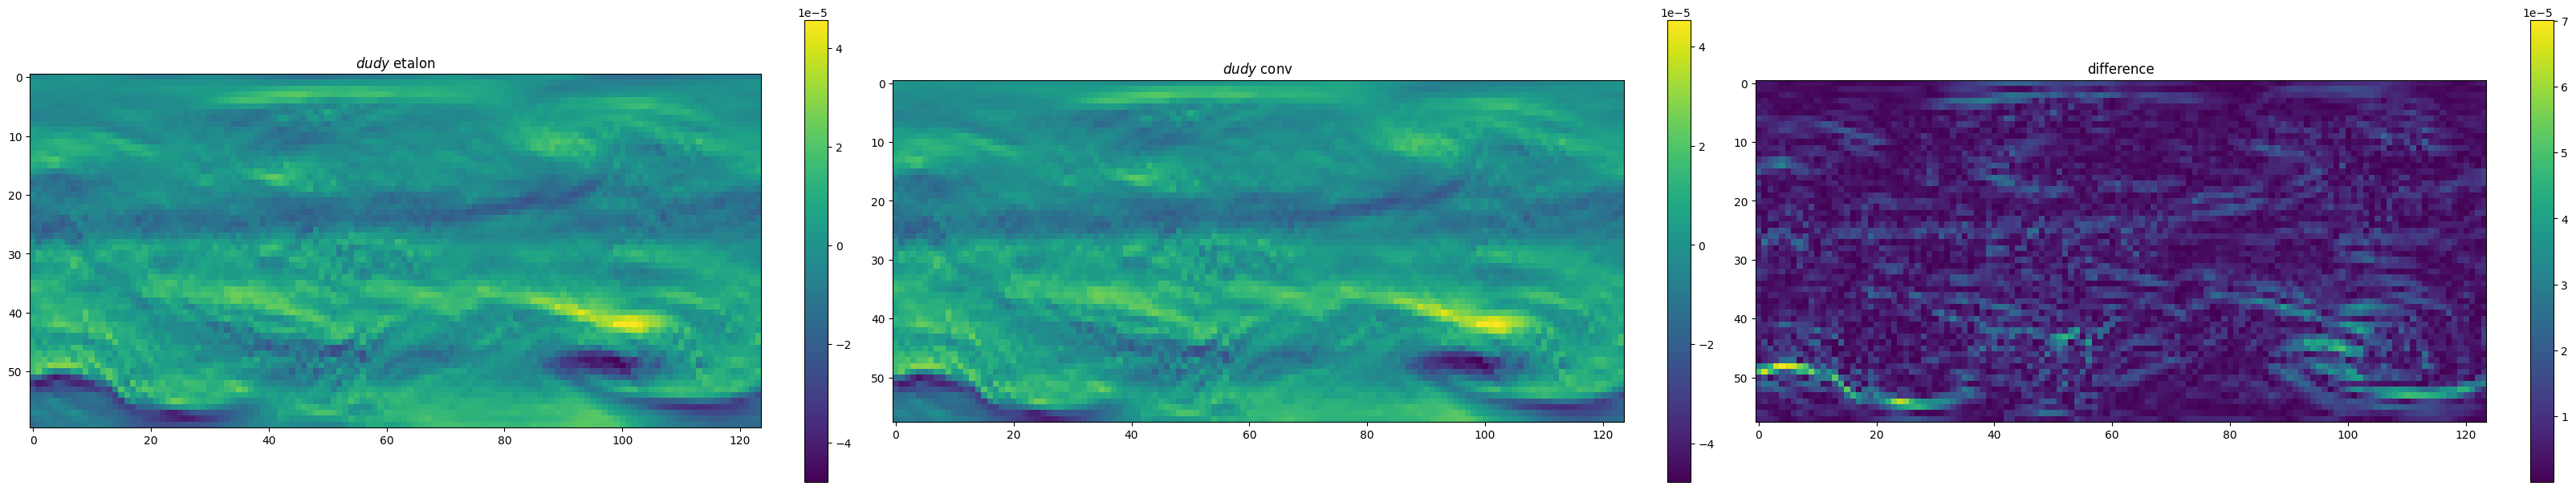

In [ ]:
plt.figure(constrained_layout=True, figsize=(32, 6))
plt.subplot(131)
plt.imshow(du_dy[:-4, 4:])
plt.title("$du dy$ etalon")
plt.colorbar()

plt.subplot(132)
plt.imshow(conv_diff_du_dy[:-4, 4:])
plt.title("$du dy$ conv")
plt.colorbar()


plt.subplot(133)
plt.imshow(np.abs(conv_diff_du_dy[:-4, 4:] - np.array(du_dy[3:-3, 4:])))
plt.title("difference")
plt.colorbar()

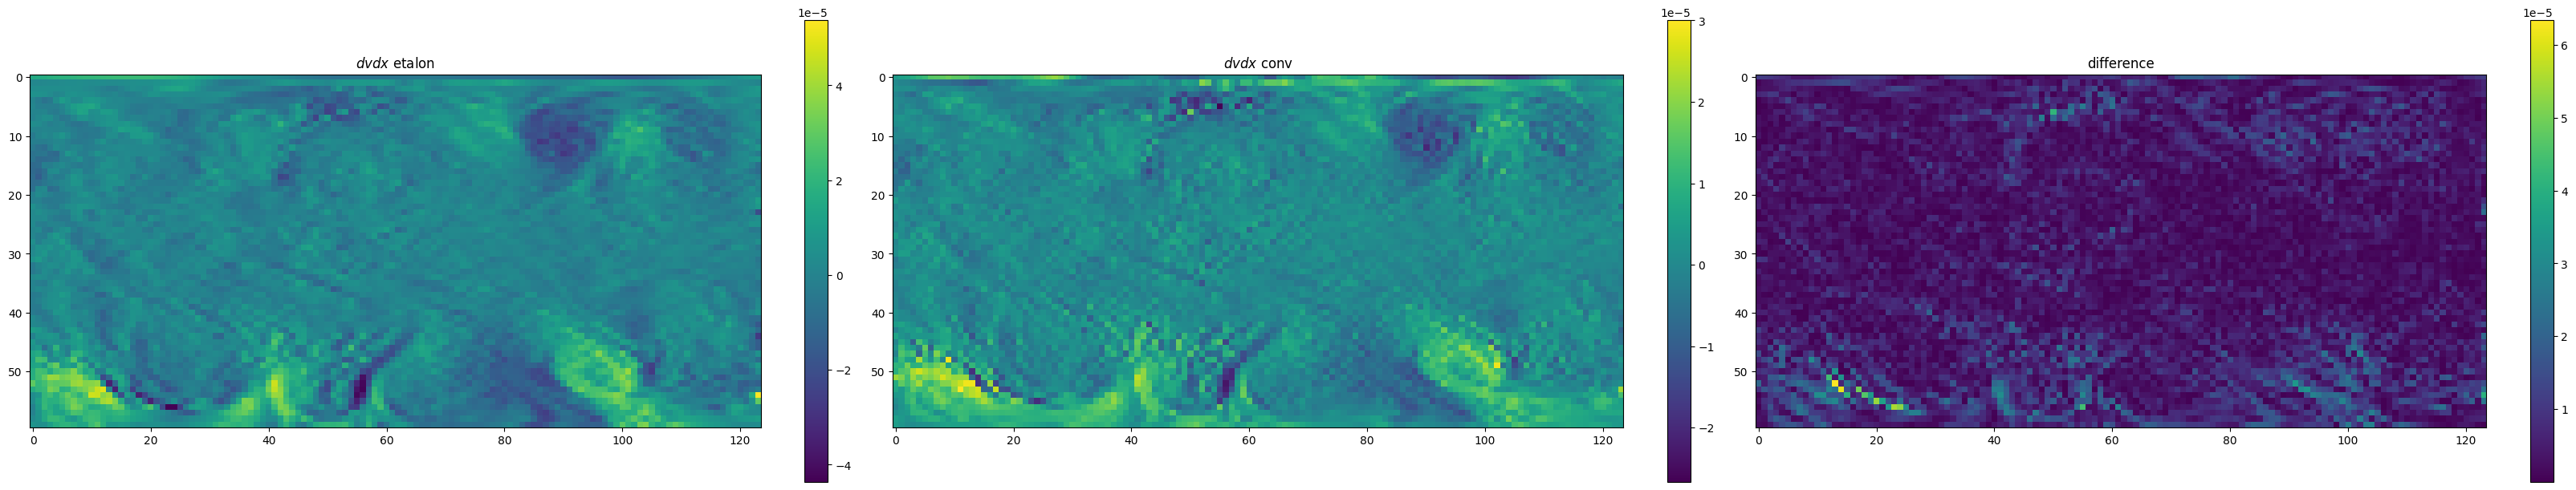

In [ ]:
plt.figure(constrained_layout=True, figsize=(32, 6))
plt.subplot(131)
plt.imshow(dv_dx[:-4, 4:])
plt.title("$dv dx$ etalon")
plt.colorbar()

plt.subplot(132)
plt.imshow(conv_diff_dv_dx[:-4, 4:])
plt.title("$dv dx$ conv")
plt.colorbar()

plt.subplot(133)
plt.imshow(np.abs(conv_diff_dv_dx[:-4, 4:] - np.array(dv_dx[:-4, 4:])))
plt.title("difference")
plt.colorbar()

У нас сетка в $\theta$ и $\phi$. Она сонаправлена XY (условно, ось У смотрит на север, ось Х - на восток).

Каждая ячейка - прямоугольная в ХУ и в $\theta$ $\phi$.

Производная по Х - разница значения справа и значения слева, поделенная на 2*ширина ячейки.

Производная по У - разница значения сверху и значения снизу, поделенная на 2*высоту ячейки.

высота ячейки одинакова и задается гранулярностью $\theta$

ширина - уменьшается к полюсам как $cos(\theta)$, но одинакова для всех матриц

In [ ]:
# dv_dx = np.diff(v_wind, axis=1, prepend=0)
# du_dy = np.diff(u_wind, axis=0, prepend=0)
diff = dv_dx - du_dy

In [ ]:
diff

dask.array<sub, shape=(64, 128), dtype=float64, chunksize=(64, 128), chunktype=numpy.ndarray> <Unit('1 / second')>

In [ ]:
vor

<xarray.DataArray 'vo' (lat: 64, lon: 128)>
dask.array<getitem, shape=(64, 128), dtype=float32, chunksize=(64, 128), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    level    int32 50
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
    time     datetime64[ns] 2002-01-01
Attributes:
    units:          s**-1
    long_name:      Vorticity (relative)
    standard_name:  atmosphere_relative_vorticity

In [ ]:
vor_to_plot = vor.to_numpy()
vor_to_plot[vor_to_plot > 0.00020] = np.mean(vor_to_plot)

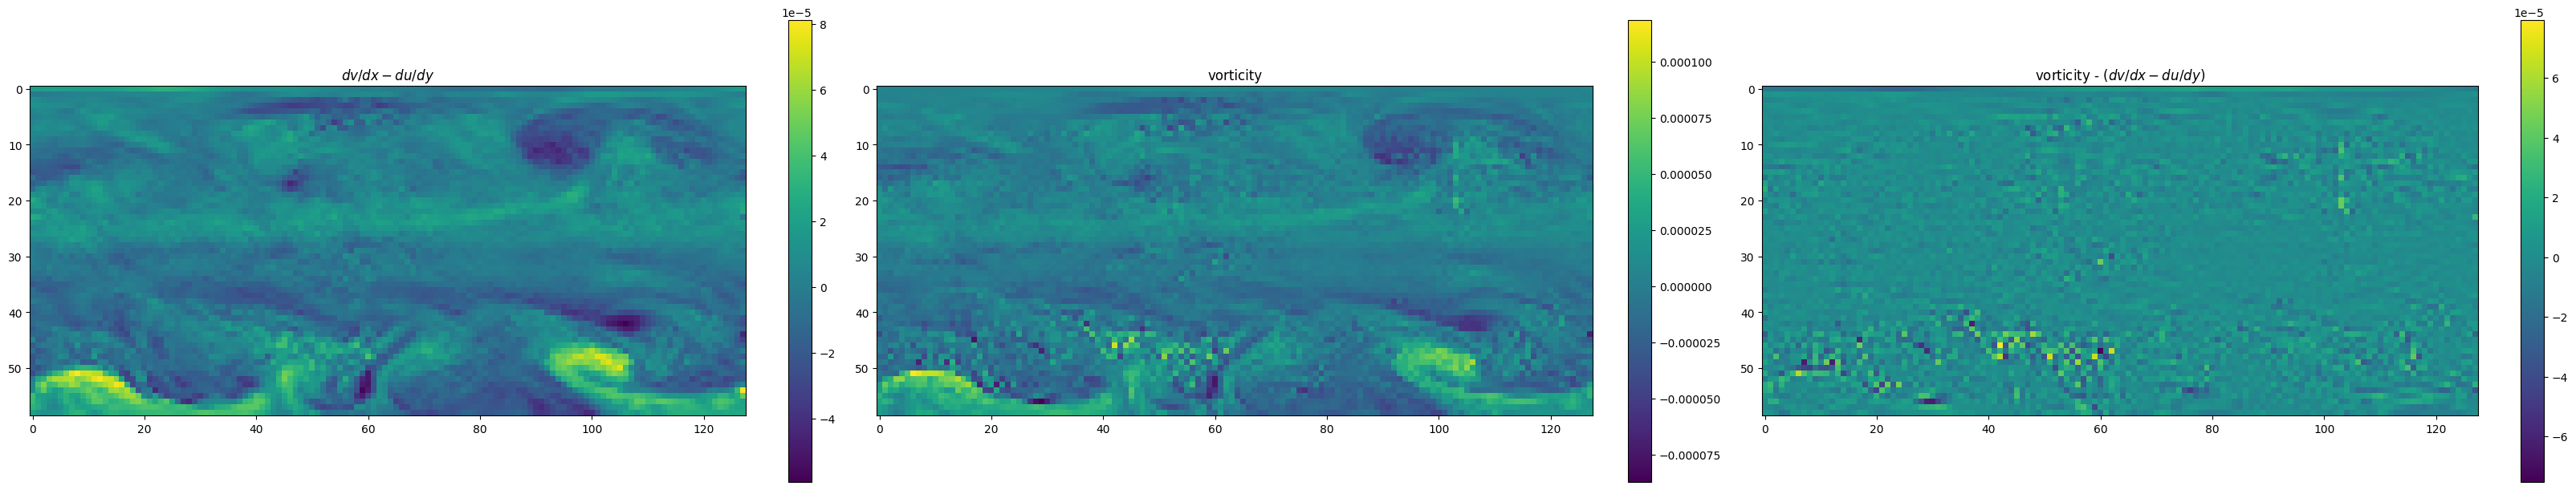

In [ ]:
plt.figure(constrained_layout=True, figsize=(32, 6))

plt.subplot(131)
plt.imshow(np.array(diff[:-5, :]))
plt.title("$dv/dx - du/dy$")
plt.colorbar()

plt.subplot(132)
plt.imshow(vor_to_plot[:-5, :])
plt.title("vorticity")
plt.colorbar()

plt.subplot(133)
plt.imshow(vor_to_plot[:-5, :] - np.array(diff[:-5, :]))
plt.title("vorticity - ($dv/dx - du/dy$)")
plt.colorbar()

In [ ]:
# array_to_plot = [np.array(diff), vor.to_numpy(), vor.to_numpy() - np.array(diff)]
array_to_plot = [np.array(diff), vor.to_numpy(), vor.to_numpy() / np.array(diff)]

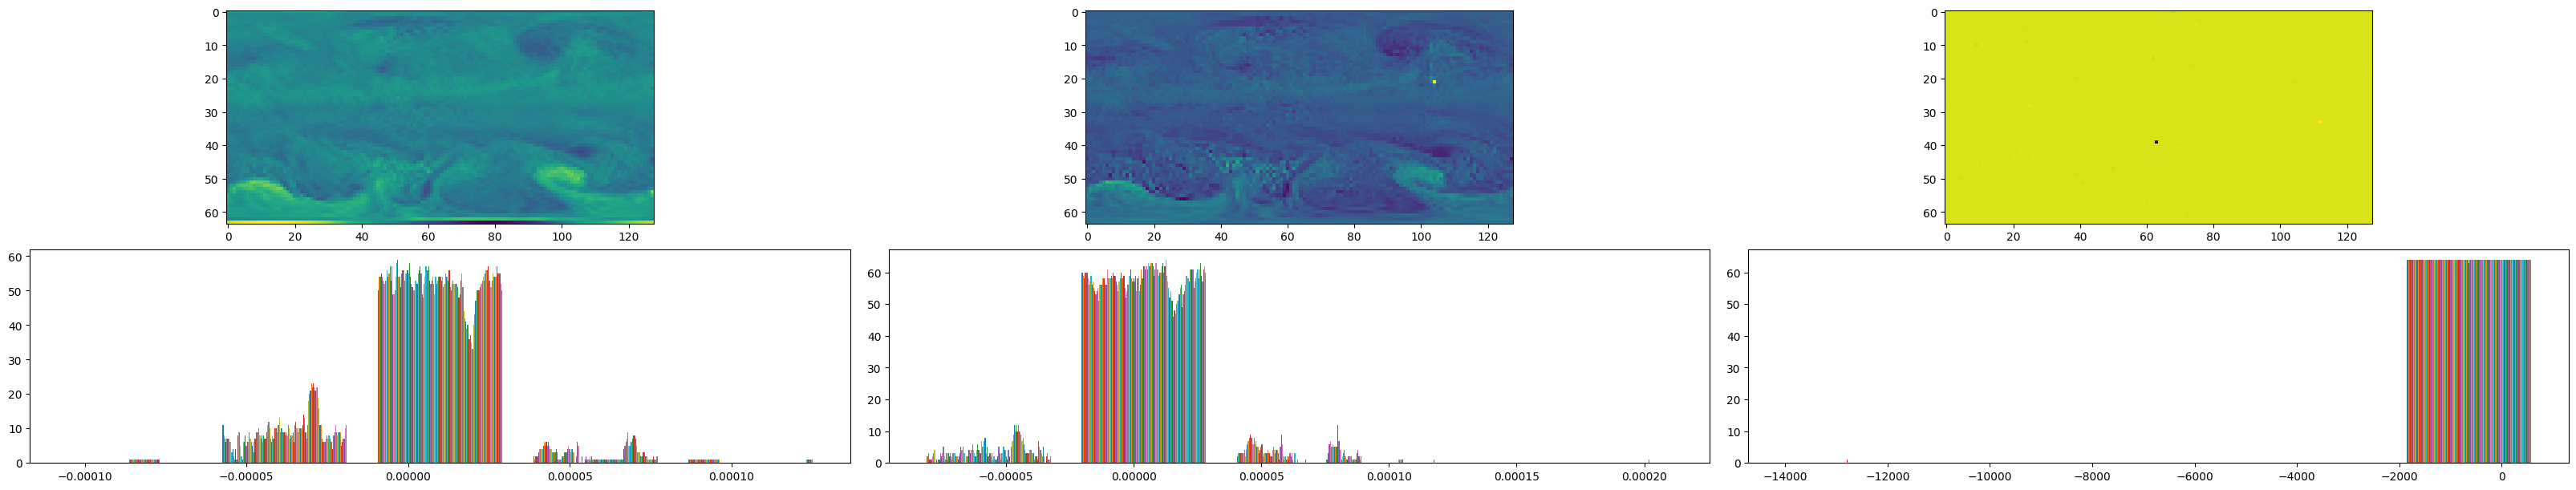

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, constrained_layout=True, figsize=(32, 6))
for idx, ax in enumerate(axes.flat):
    if idx < 3:
        im = ax.imshow(array_to_plot[idx])
    else:
        im = ax.hist(array_to_plot[idx-3],  bins=5)

# fig.subplots_adjust(right=0.8)
# fig.colorbar(im)

plt.show()